## Finetuning Facial Recognition on Bounded Faces Passed from MTCNN for Face Alignment.

This code is adapted for our use case from Mike Chaykowsky's excellent tutorial: https://towardsdatascience.com/finetune-a-facial-recognition-classifier-to-recognize-your-face-using-pytorch-d00a639d9a79

In [4]:
#To prevent TLS Block error 
#export LD_PRELOAD = /usr/lib/aarch64-linux-gnu/libgomp.so.1

SyntaxError: invalid syntax (<ipython-input-4-3ff02a16a489>, line 2)

In [1]:
#Import libraries
#import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#from skimage import io, transform
#from tqdm import trange, tqdm
import csv
import glob
#import dlib
import pandas as pd
import numpy as np

from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from models.inception_resnet_v1 import InceptionResnetV1


#### Determine if GPU is available. 

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### 1.) Load Data

In [3]:
#Perform transforms and normalization to prepare images for training on ResNet
data_transforms = {
    'train': transforms.Compose([
        #Note: Our images must be 160x160 for model (Training & Val). 
        transforms.Resize(size = (160,160)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size = (160,160)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'data/train_val'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['Diana_Chacon', 'Jerico_Johns', 'Josh_Jonte', 'Sudhrity_Mondal']

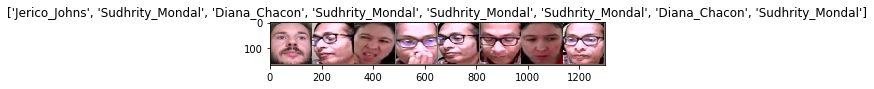

In [4]:
#Show some images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

#### 2.) Load Pretrained ResNet (on VGGFace2 Dataset)

In [5]:
#Load the pretrained model
from models.inception_resnet_v1 import InceptionResnetV1
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

Running on device: cuda:0


100.0%


#### 3.) Freeze the earliest layers. Up until the last convolutional block. 

In [6]:
#Check the last 6 layers
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [7]:
#Remove the last layers after conv block and place in layer_list .
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [8]:
#Put all beginning layers in an nn.Sequential . 
#model_ft is now a torch model but without the final linear, pooling, batchnorm, and sigmoid layers.
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [9]:
#Set requires_grad false for all prior layers (to freeze them).
for param in model_ft.parameters():
    param.requires_grad = False

In [10]:
#In order to reattach and train the linear layer in our last 5 layers,
#we need to write two custom classes to implement and reattach. 
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [11]:
#Now we can apply final layers back to the new Sequential model. 
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
#Note: Layers have changed since tutorial, so need to customize to match current state. 
model_ft.dropout = nn.Dropout(p = 0.6, inplace = False)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
#Note: Our 2nd linear layer is layer index 4. 
model_ft.logits = nn.Linear(layer_list[4].in_features, len(class_names))

#model_ft.softmax = nn.Softmax(dim=1)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#### 4.) Train Method to (Re)Train last layers on our custom data.

In [12]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))#
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

#### 5.) (Re)Train our model and evaluate on Val Images. 

Epoch 0/9
----------
train Loss: 1.3339 Acc: 0.7397
val Loss: 1.2837 Acc: 0.9565
Epoch 1/9
----------
train Loss: 1.3267 Acc: 0.7940
val Loss: 1.2835 Acc: 0.9391
Epoch 2/9
----------
train Loss: 1.3275 Acc: 0.7809
val Loss: 1.2841 Acc: 0.9522
Epoch 3/9
----------
train Loss: 1.3265 Acc: 0.8015
val Loss: 1.2833 Acc: 0.9435
Epoch 4/9
----------
train Loss: 1.3252 Acc: 0.8333
val Loss: 1.2838 Acc: 0.9435
Epoch 5/9
----------
train Loss: 1.3245 Acc: 0.7959
val Loss: 1.2839 Acc: 0.9435
Epoch 6/9
----------
train Loss: 1.3254 Acc: 0.8127
val Loss: 1.2838 Acc: 0.9522
Epoch 7/9
----------
train Loss: 1.3265 Acc: 0.8071
val Loss: 1.2846 Acc: 0.9348
Epoch 8/9
----------
train Loss: 1.3259 Acc: 0.7978
val Loss: 1.2845 Acc: 0.9435
Epoch 9/9
----------
train Loss: 1.3262 Acc: 0.7903
val Loss: 1.2834 Acc: 0.9435
Training complete in 2m 44s
Best val Acc: 0.956522


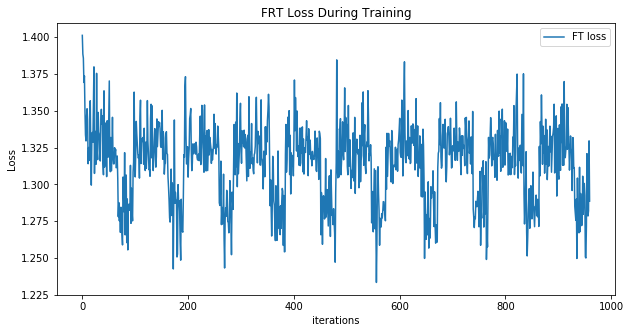

In [13]:
#Note: Up the epochs to 500 to do full training. 
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### 6.) Save the updated model as a new model in /models dir. 

In [14]:
torch.save(model_ft, 'models/face_recognition_transf.pt')